# Import packages

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import scvelo as scv
import scanpy as sc
import anndata as ad
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import poisson_atac as patac
from poisson_atac.experiments.atac_to_atac.experiment_runner import get_experiment
from poisson_atac.utils import load_experiment

[rank: 0] Global seed set to 0
/data/nasif12/home_if12/martensl/github_repos/scatac_poisson_private/poisson_atac/utils.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use("seaborn-poster")


In [4]:
from utils import cell_types, plot_regions

In [5]:
fig_path = '/s/project/poisson_atac/panels/revision2/Figure2/cell_separation/'
data_path = '/s/project/poisson_atac/panels/revision2/Figure2/data/'
save_path = '/s/project/poisson_atac/'

In [6]:
scv.set_figure_params()
sc.settings.figdir = os.path.join(fig_path)

# Load gene expression

In [7]:
gex_data_path = os.path.join(save_path, 'anndata', 'openproblems_bmmc_multiome_phase2.manual_formatting.output_rna.h5ad')

In [8]:
adata_gex = ad.read(gex_data_path)

/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/pct_counts_mt' was written without encoding metadata.
  return func(*args, **kwargs)
/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/n_counts' was written without encoding metadata.
  return func(*args, **kwargs)
/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/n_genes' was written without encoding metadata.
  return func(*args, **kwargs)
/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/anndata/_io/u

## Load annotation

In [9]:
annotation_great = pd.read_csv(os.path.join(save_path,'biological_analysis', 'annotation', 'great_regdom_annotation.csv'), index_col=0)

In [10]:
annotation_great.index = annotation_great.Chromosome + '-' + annotation_great.Start.astype(str) + '-' + annotation_great.End.astype(str)

# Load models

In [11]:
adata = patac.data.load_neurips(batch=None, only_train=False)

/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/nCount_peaks' was written without encoding metadata.
  return func(*args, **kwargs)
/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/atac_fragments' was written without encoding metadata.
  return func(*args, **kwargs)
/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/reads_in_peaks_frac' was written without encoding metadata.
  return func(*args, **kwargs)
/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packa

In [12]:
model_hash =  {'binaryvi': os.path.join(data_path, 'acc_binaryvi_6.csv'), 'poissonvi': os.path.join(data_path, 'acc_poissonvi_6.csv')} # the best models according to average precision

## Binary VI

In [13]:
if not os.path.exists(model_hash['binaryvi']):
    binaryvi = patac.model.BinaryVI.load(
        adata=adata, 
        dir_path=os.path.join(save_path, 'models', 'neurips', 'binaryvi', model_hash['binaryvi'])
    )

## Poisson VI

In [14]:
if not os.path.exists(os.path.join(data_path, model_hash['poissonvi'])):
    poissonvi = patac.model.PoissonVI.load(
        adata=adata, 
        dir_path=os.path.join(save_path, 'models', 'neurips', 'poissonvi', model_hash['poissonvi'])
    )

# Compute normalized accessibility

In [15]:
correlations = pd.read_csv(os.path.join(save_path, 'biological_analysis', 'correlations_size_factor_subset.csv'), index_col=0)

In [16]:
correlations = correlations[correlations.pvalue < 0.05].sort_values('correlation', ascending=False)

In [17]:
regions = correlations.head(30).index.to_list()

In [18]:
m_size_factor = adata.obs.size_factor.median()
m_size_factor

3696.0

In [19]:
if not os.path.exists(model_hash['poissonvi']):
    acc = poissonvi.get_accessibility_estimates(
                return_numpy=False,
                n_samples=1,
                library_size=m_size_factor,
        region_list=regions
            )
    acc.to_csv(model_hash['poissonvi'])
else:
    acc = pd.read_csv(model_hash['poissonvi'], index_col=0)

In [20]:
if not os.path.exists(model_hash['binaryvi']):
    acc_binary = binaryvi.get_accessibility_estimates(
                return_numpy=False,
                n_samples=1, 
                library_size=m_size_factor,
                logit=False,
        region_list=regions
            )
    acc_binary.to_csv(model_hash['binaryvi'])
else:
    acc_binary = pd.read_csv(model_hash['binaryvi'] ,index_col=0)

In [21]:
# get predictions for all cells available
if not os.path.exists(os.path.join(data_path, 'acc_cistopic.csv')):
    acc_cistopic_list =  [
        pd.read_csv(os.path.join(data_path, f'acc_cistopic_{seed}.csv'), index_col=0)
        for seed in [0, 1 ,2, 3, 4, 5, 6, 7, 8, 9]
    ]
    acc_cistopic = pd.concat(acc_cistopic_list)
    acc_cistopic = acc_cistopic.reset_index().drop_duplicates('index').set_index('index')
    acc_cistopic = acc_cistopic.loc[adata.obs_names].copy()
    acc_cistopic.to_csv(os.path.join(data_path, 'acc_cistopic.csv'))
else: 
    acc_cistopic = pd.read_csv(os.path.join(data_path, 'acc_cistopic.csv'), index_col=0)

## Check which cell_types express the gene

/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


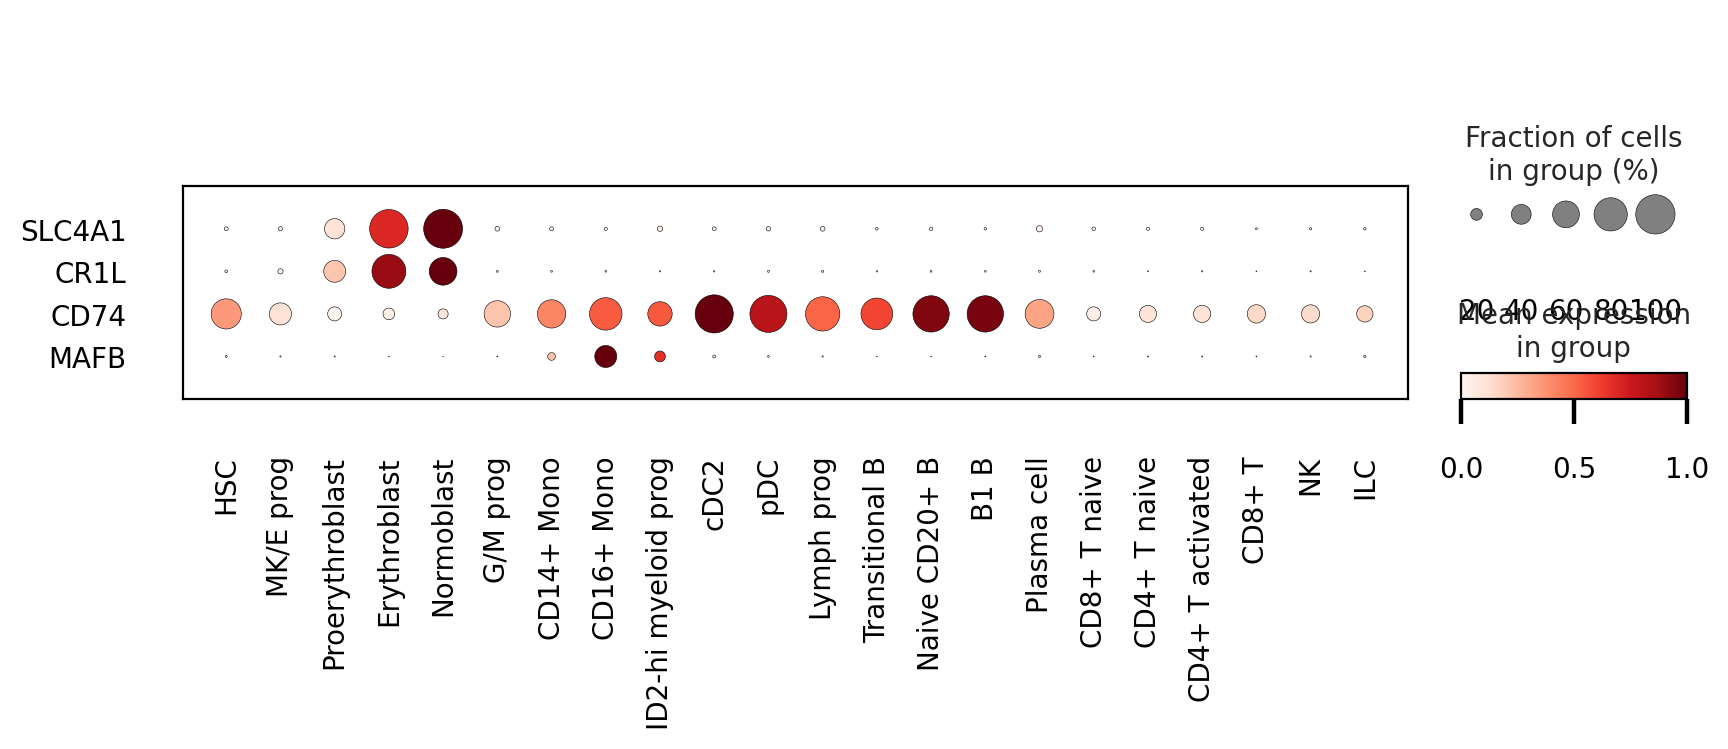

/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


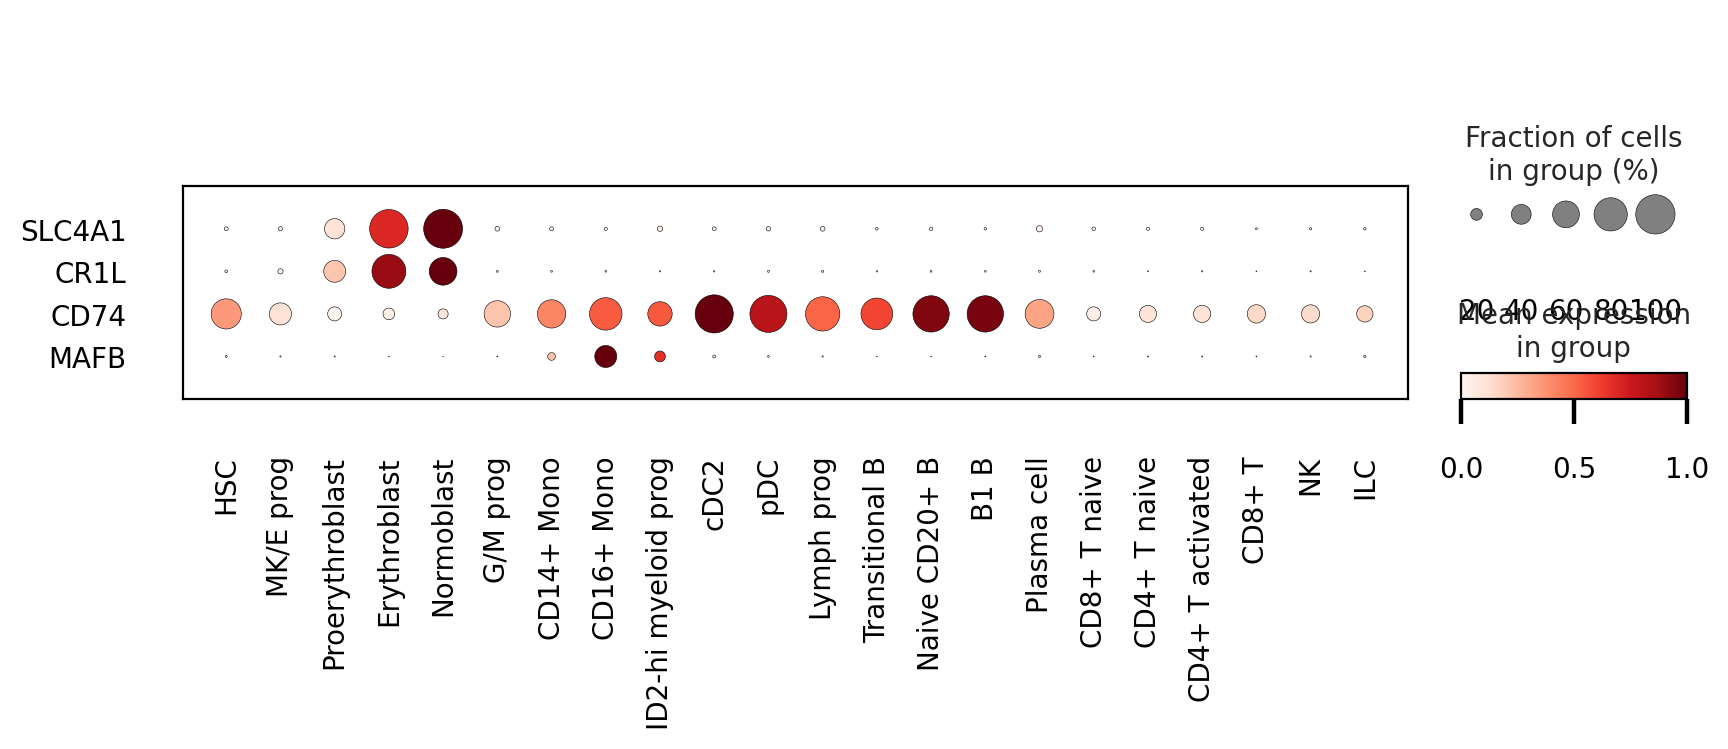

In [22]:
adata_gex.obs.cell_type = pd.Categorical(adata_gex.obs.cell_type, categories=cell_types)
sc.pl.dotplot(
    adata_gex, 
    var_names=["SLC4A1", "CR1L", "CD74", "MAFB"], 
    groupby='cell_type', 
    standard_scale='var', 
    swap_axes=True, 
    save='_markers.png'
)
sc.pl.dotplot(
    adata_gex, 
    var_names=["SLC4A1", "CR1L", "CD74", "MAFB"], 
    groupby='cell_type', 
    standard_scale='var', 
    swap_axes=True, 
    save='_markers.pdf'
)

## Plot regions

In [23]:
region_dict = {
    'chr17-44267801-44268699': [ 'Proerythroblast', 'Erythroblast', 'Normoblast'],
    'chr20-40688852-40689723': ['CD14+ Mono', 'CD16+ Mono', 'ID2-hi myeloid prog'],
    'chr1-207644614-207645499': [ 'Proerythroblast', 'Erythroblast', 'Normoblast'],
    'chr5-150412442-150413366': ['Lymph prog', 'B1 B']
}

SLC4A1


2023-05-25 14:41:28 (WARNING): No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


SLC4A1


2023-05-25 14:41:33 (WARNING): No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


SLC4A1


2023-05-25 14:41:39 (WARNING): No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAFB


2023-05-25 14:41:42 (WARNING): No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAFB


2023-05-25 14:41:46 (WARNING): No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAFB


2023-05-25 14:41:50 (WARNING): No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CR1L


2023-05-25 14:41:56 (WARNING): No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CR1L


2023-05-25 14:42:01 (WARNING): No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CR1L


2023-05-25 14:42:06 (WARNING): No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CD74


2023-05-25 14:42:09 (WARNING): No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CD74


2023-05-25 14:42:12 (WARNING): No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CD74


2023-05-25 14:42:15 (WARNING): No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


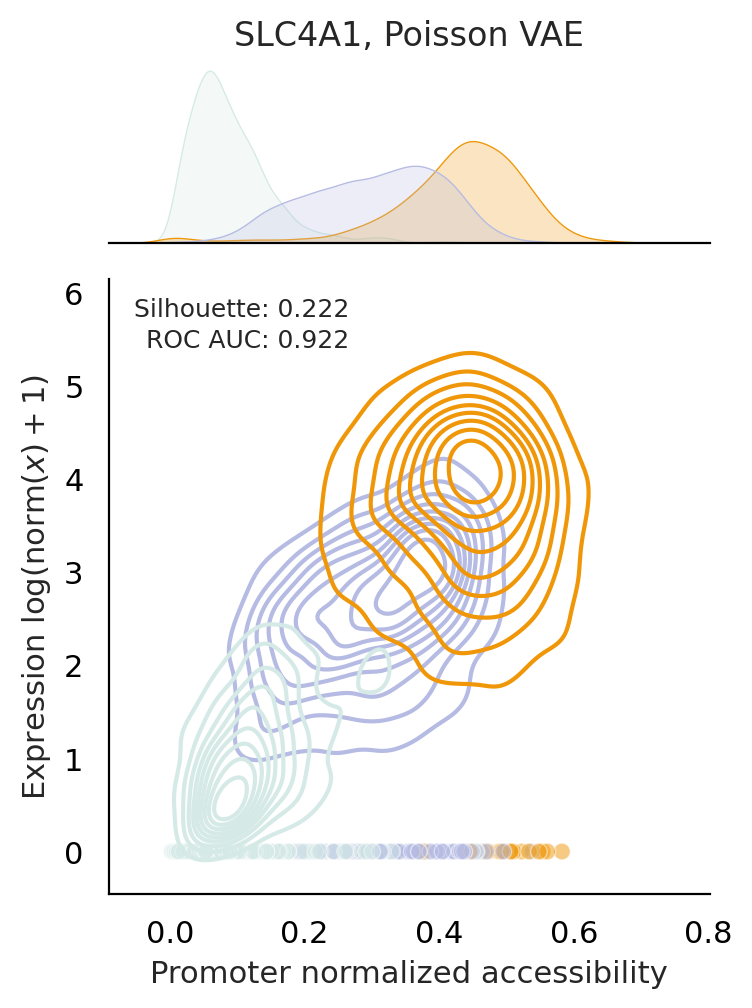

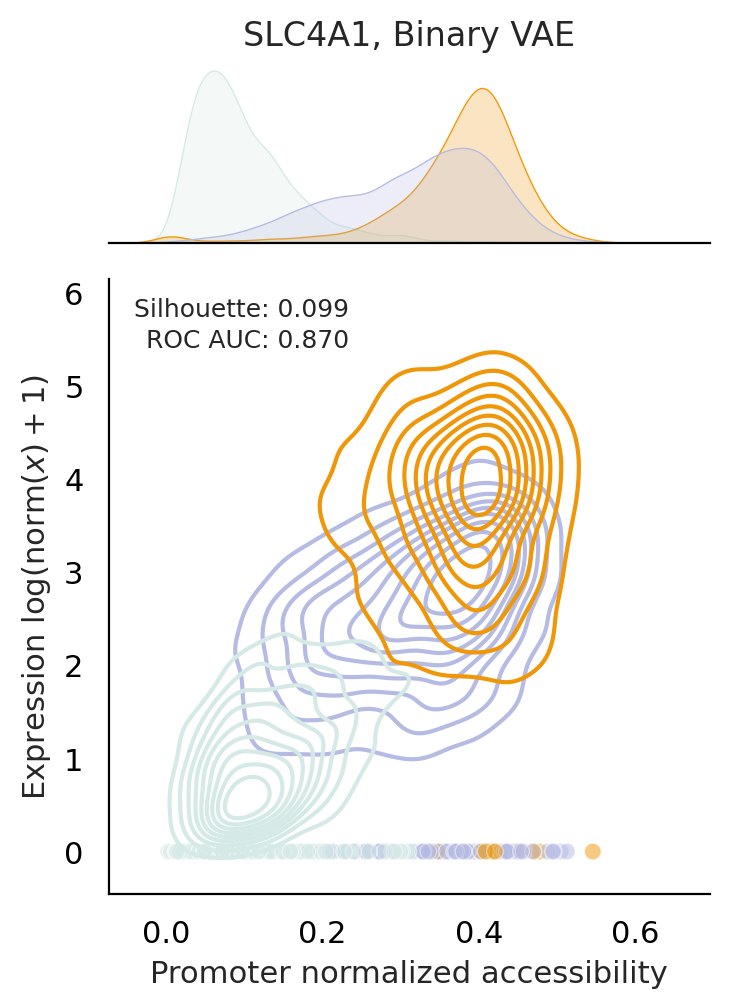

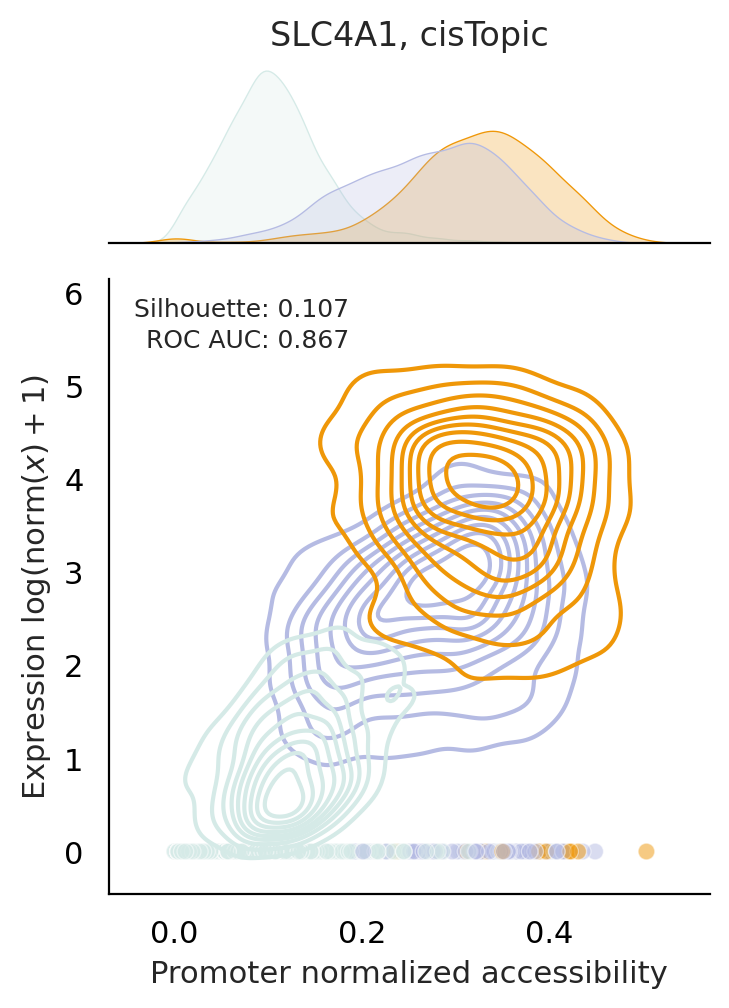

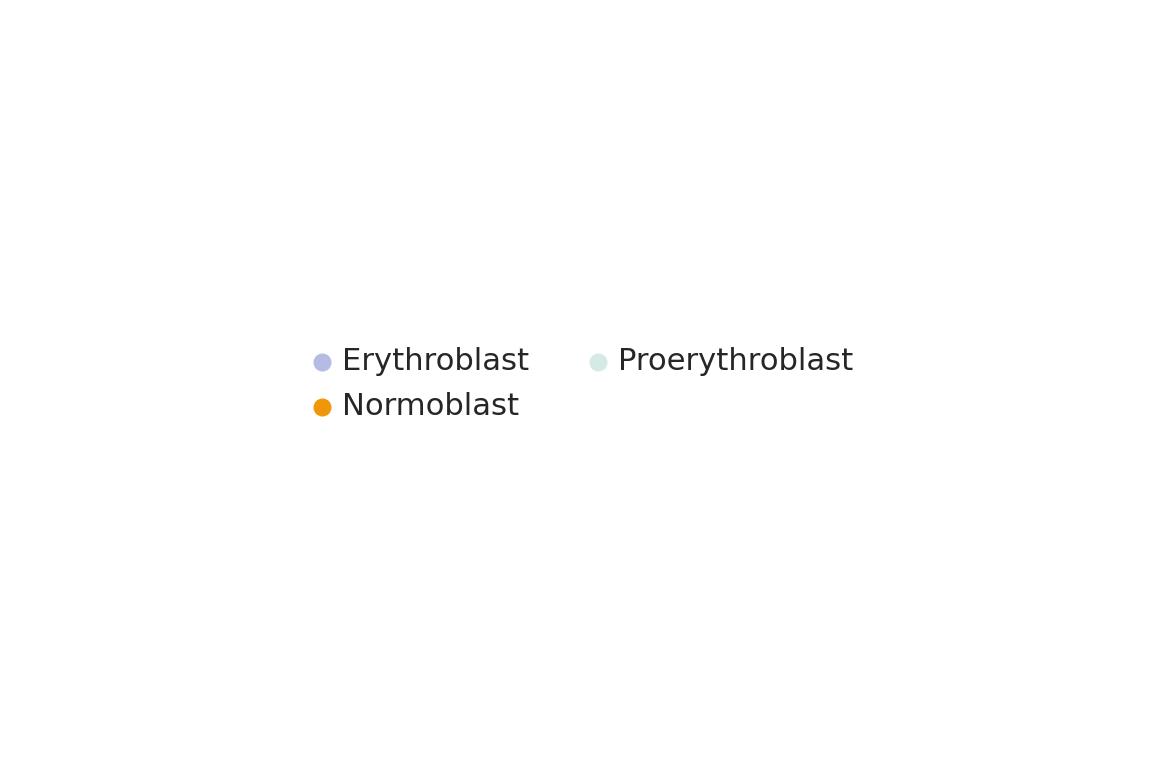

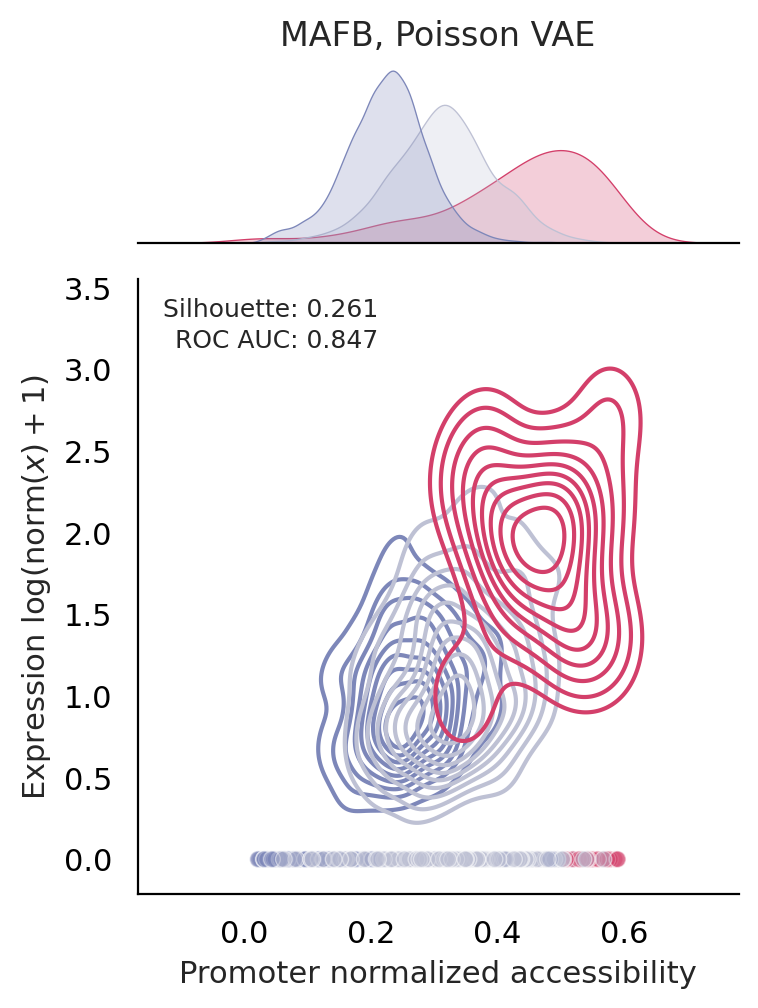

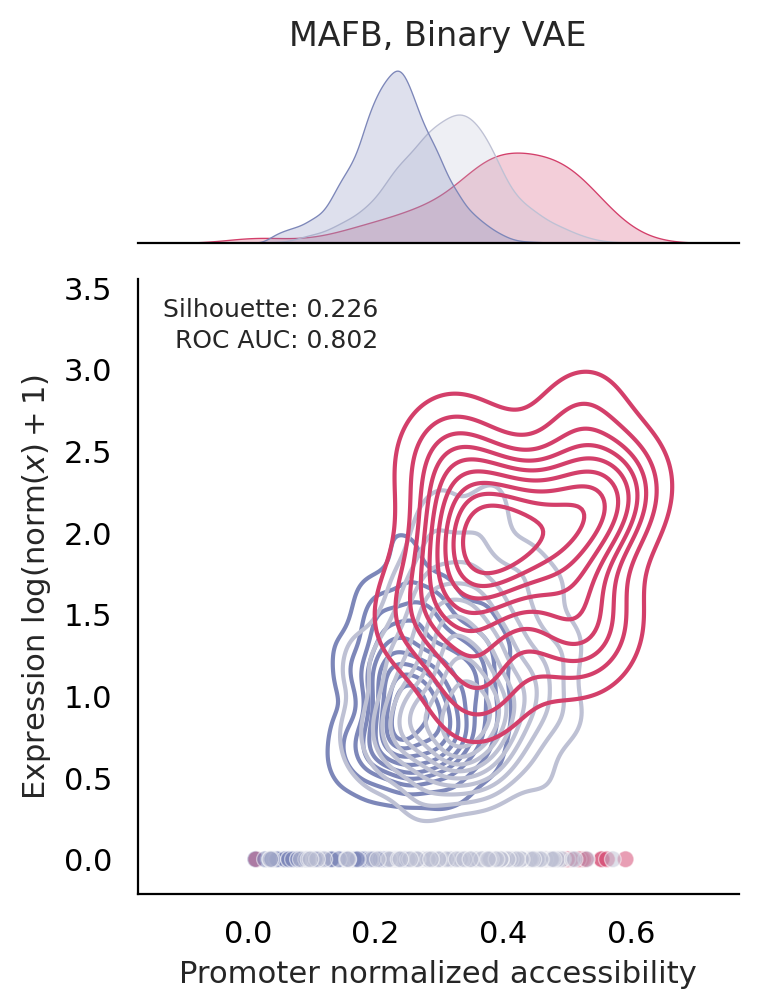

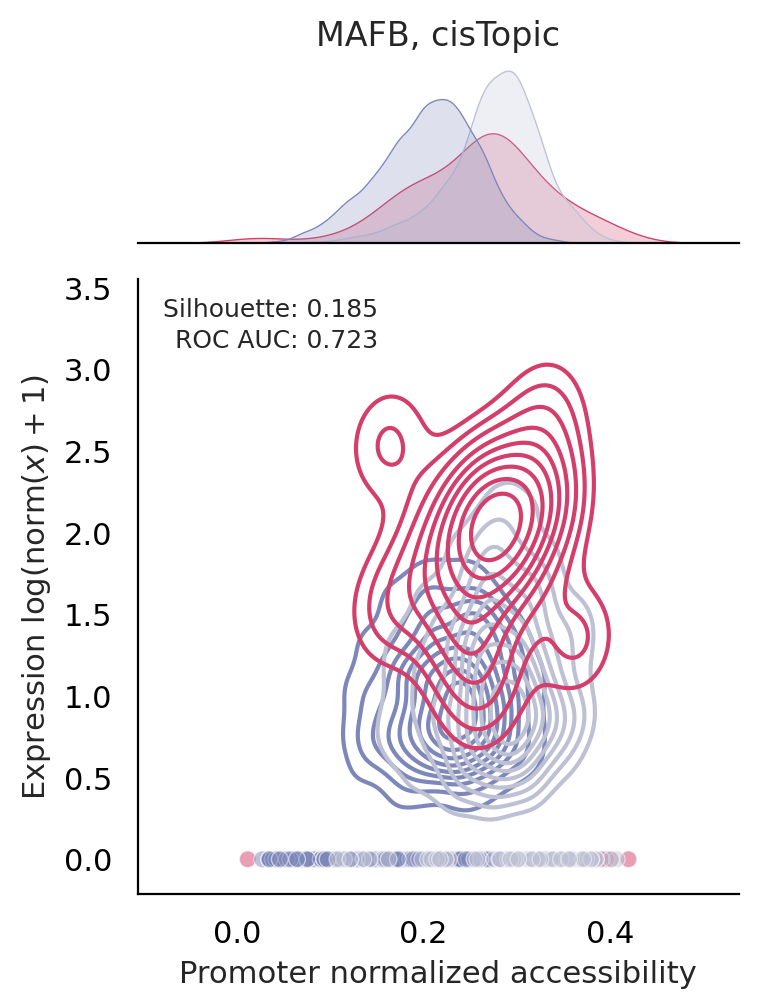

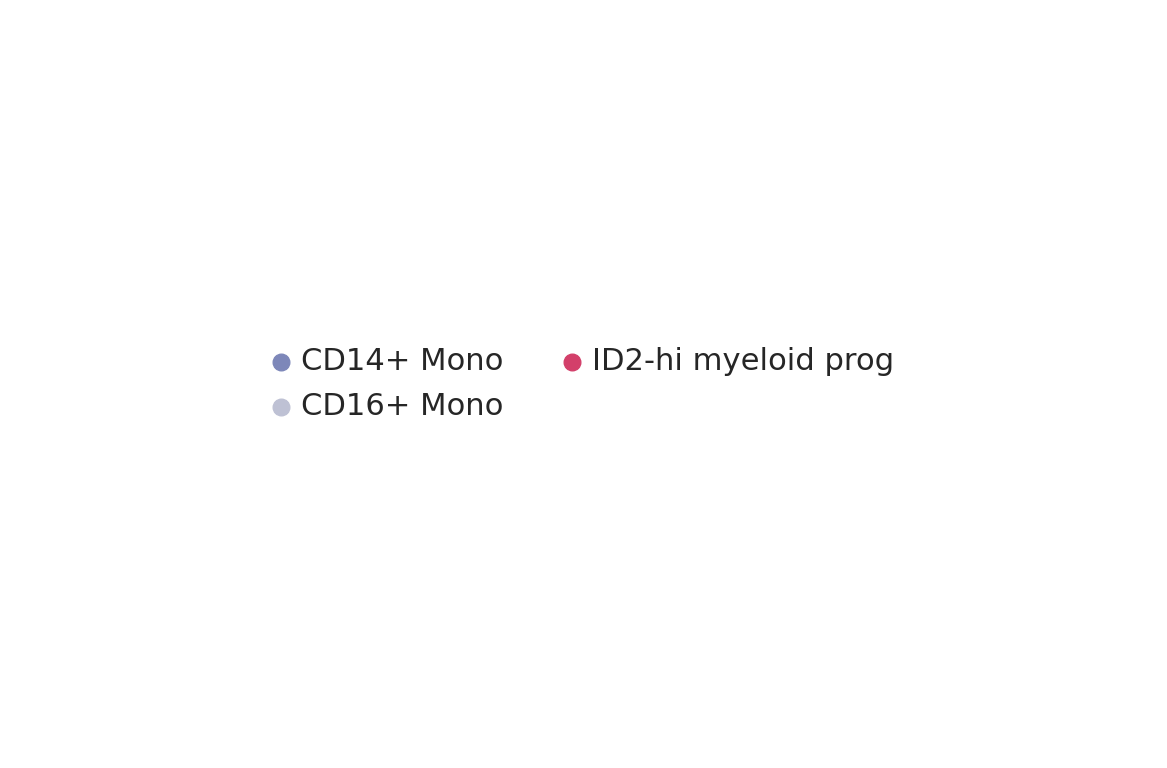

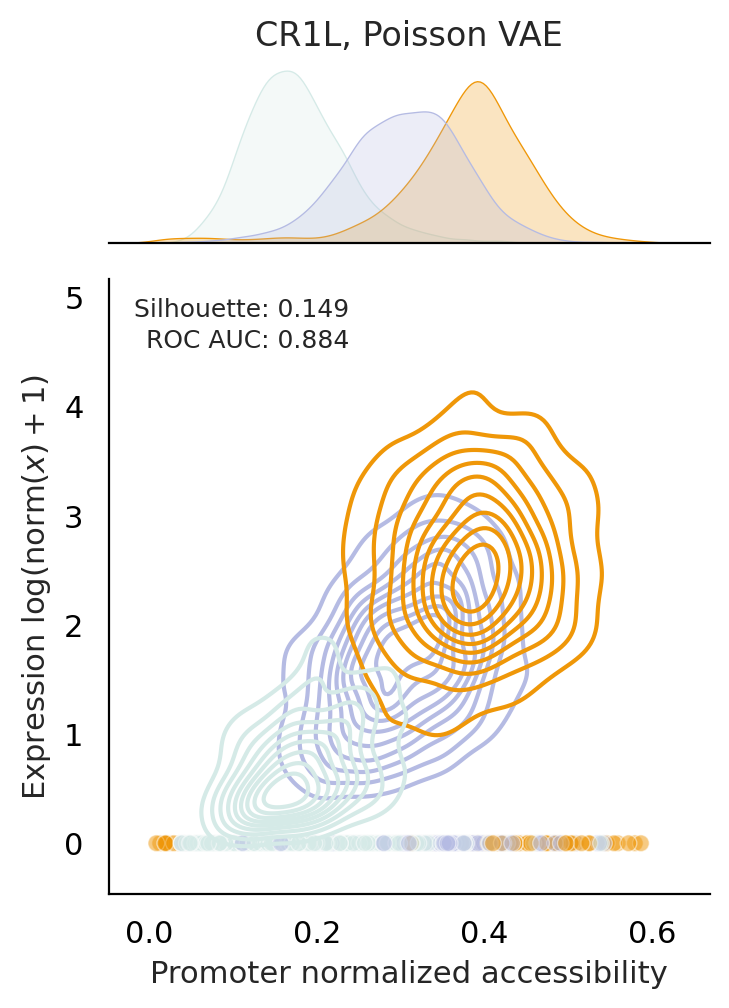

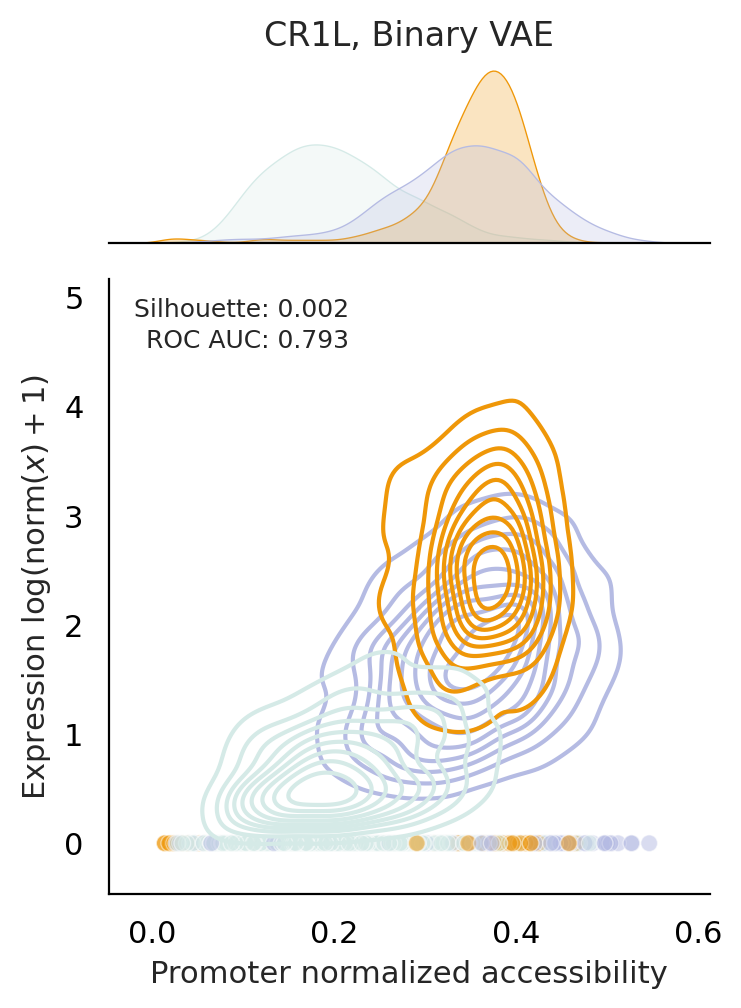

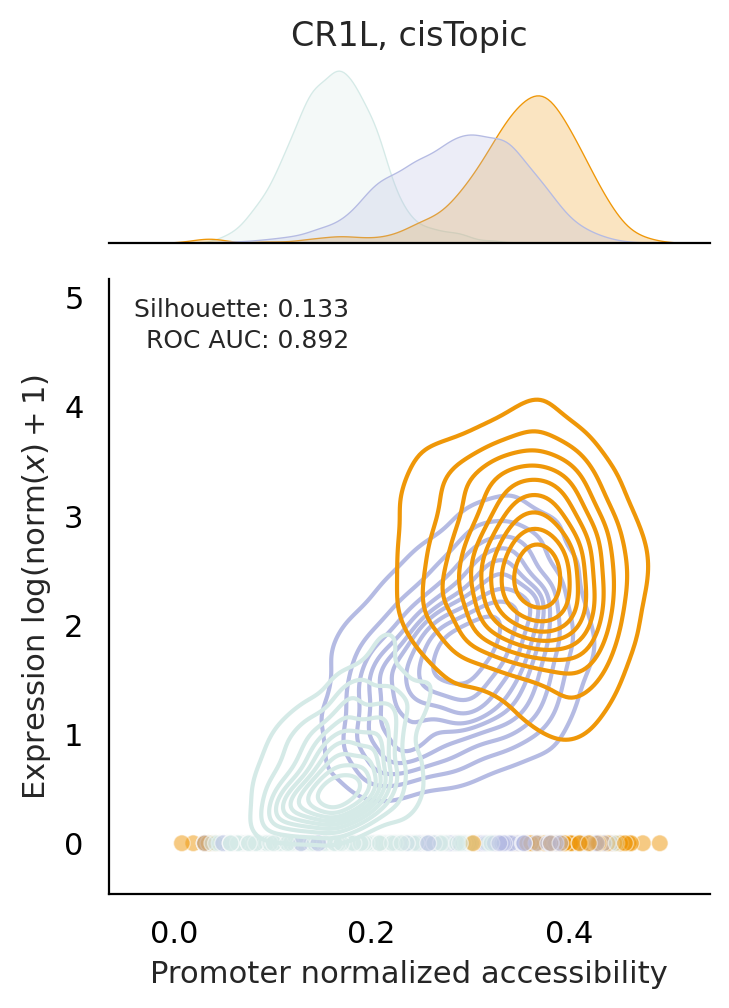

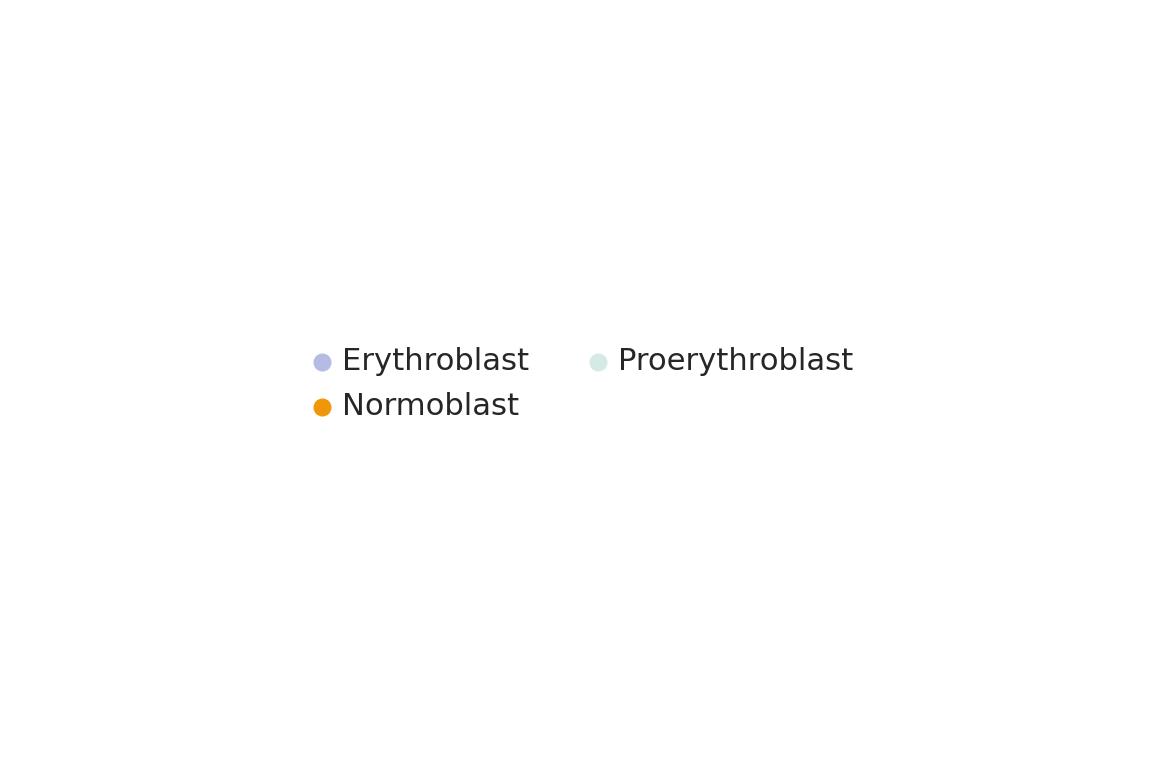

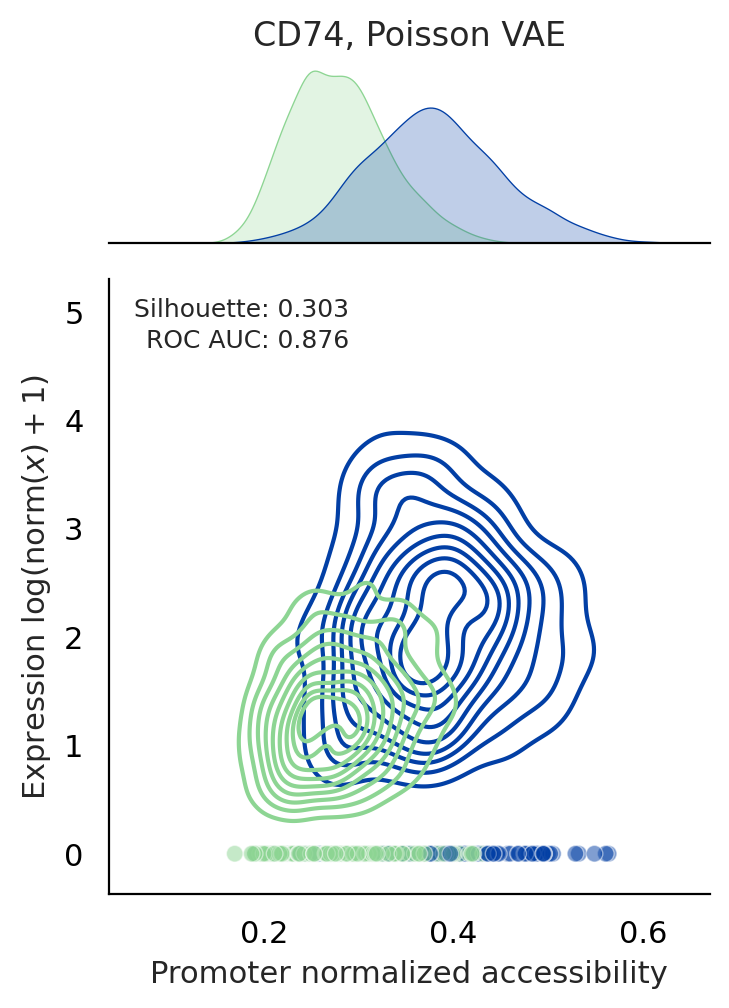

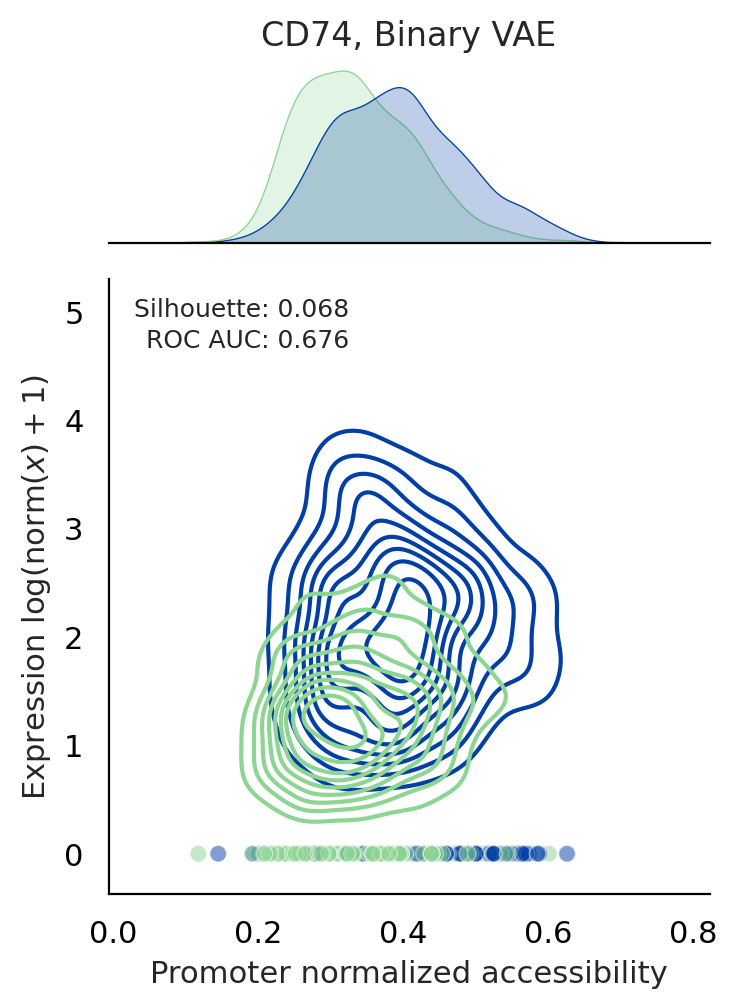

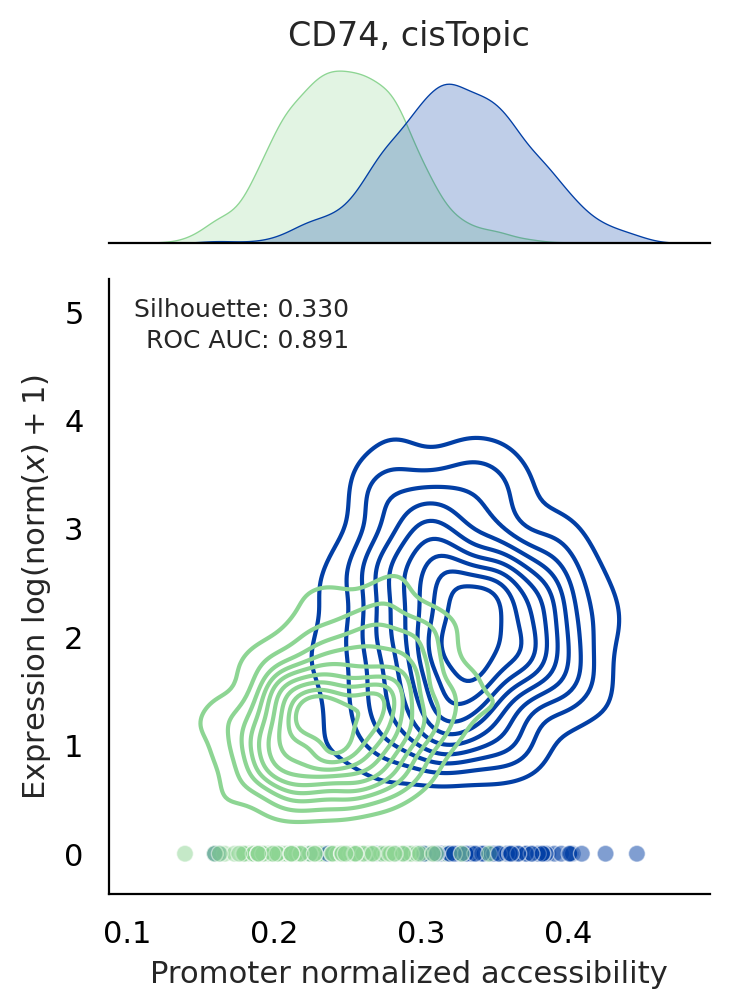

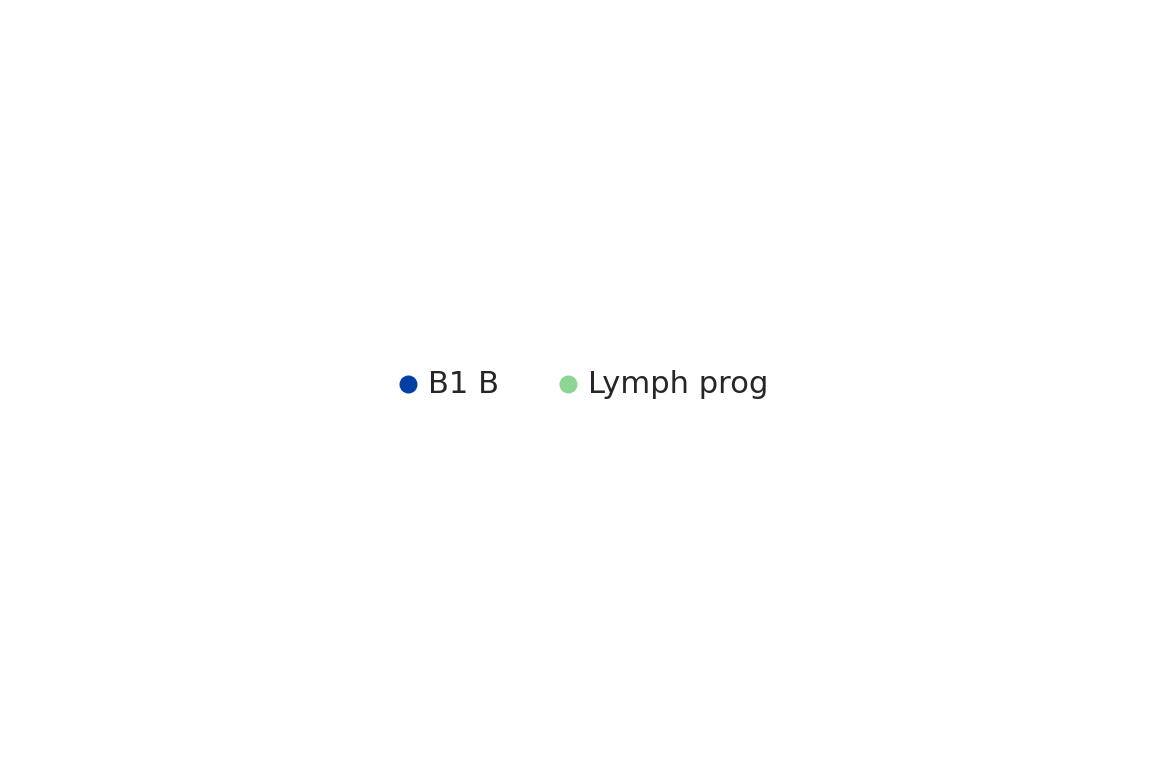

In [35]:
for region, cell_types in region_dict.items():
    plot_regions(
        region=region, 
        correlation=correlations, 
        adata=adata, 
        adata_gex=adata_gex, 
        acc=acc, 
        label= 'Poisson VAE',
        cell_types = cell_types, 
        save_path=fig_path
    )
    plot_regions(
        region=region, 
        correlation=correlations, 
        adata=adata, 
        adata_gex=adata_gex, 
        acc=acc_binary, 
        label= 'Binary VAE',
        cell_types = cell_types, 
        save_path=fig_path
    )
    plot_regions(
        region=region, 
        correlation=correlations, 
        adata=adata, 
        adata_gex=adata_gex, 
        acc=acc_cistopic,  
        label='cisTopic',
        cell_types = cell_types, 
        save_path=fig_path
    )
    
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.figure()
    plt.axis("off")  # Turn off the axis
    plt.legend(handles, labels, ncol=2, loc="center", frameon=False)

    # Show the plots
    plt.tight_layout()
    plt.savefig(
        os.path.join(fig_path, f"{'_'.join(cell_types)}_legend.pdf"),
        bbox_inches="tight",
    )